# SOG Model Freshwater Chemistry Analysis
### Sections
   1. [Local Functions](#Local-Functions)
   2. [Load SOG Data](#Load-SOG-Data)
   3. [TA regressions](#TA-regressions)
   4. [Fraser River Buoy pH Data](#Fraser-River-Buoy-pH-Data)
   5. [Freshwater DIC scenarios](#Freshwater-DIC-scenarios)
   6. [Flow Record](#Flow-Record)
   7. [SOG Results](#SOG-Results)

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import SOG_loader
import carbonate
import yaml
import os
import gsw
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from scipy.io import loadmat
from matplotlib import gridspec

%matplotlib inline

## Local Functions

In [3]:
def export_TA_record(TA_record):
    """
    """
    
    # Create new forcing file
    Fraser_file = pd.read_csv(
        '/ocean/bmoorema/research/SOG/SOG-forcing/rivers/Fraser_total_31May2013.dat',
        delim_whitespace=True, names=['year', 'month', 'day', 'flow'],
    )
    Fraser_file = Fraser_file.join(pd.DataFrame(TA_record, columns=['TA']))
    #Fraser.to_csv('/ocean/bmoorema/research/SOG/SOG-forcing/rivers/FraserTA.dat', sep=' ', header=False, index=False)

In [9]:
def load_SOG_dict(results, path):
    """
    """
    
    # Parse run tag
    key = os.path.split(path)[1]
    year = key.split('_')[0]
    chemstr = key.split('TA')[1].split('pH')
    TA = chemstr[0]
    pH = chemstr[1]
    
    # Initialize run dict
    results[pH][TA][year] = {}
    
    # Load timeseries
    TS_phys = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_phys_SOG.out'))
    TS_chem = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_chem_SOG.out'))
    TS_bio = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_bio_SOG.out'))
    
    # Extract physics fields
    results[pH][TA][year]['t'] = TS_phys['3 m avg temperature']              # in situ temperature [deg C]
    results[pH][TA][year]['SP'] = TS_phys['3 m avg salinity']                # practical salinity  [PSS 78]
    
    # Calculate and assign TEOS-10 properties
    results[pH][TA][year]['SR'] = gsw.conversions.SR_from_SP(results[pH][TA][year]['SP'])
    results[pH][TA][year]['CT'] = gsw.conversions.CT_from_t(results[pH][TA][year]['SR'], results[pH][TA][year]['t'], 0)
    results[pH][TA][year]['rho'] = gsw.density.rho(results[pH][TA][year]['SR'], results[pH][TA][year]['CT'], 0)
    
    # Extract bio and chem fields
    results[pH][TA][year]['NO3'] = TS_bio['3 m avg nitrate concentration'] * 1e3 / results[pH][TA][year]['rho']
    results[pH][TA][year]['NH4'] = TS_bio['3 m avg ammonium concentration'] * 1e3 / results[pH][TA][year]['rho']
    results[pH][TA][year]['Si'] = TS_bio['3 m avg silicon concentration'] * 1e3 / results[pH][TA][year]['rho']
    results[pH][TA][year]['DIC'] = TS_chem['3 m avg DIC concentration'] * 1e3 / results[pH][TA][year]['rho']
    results[pH][TA][year]['TA'] = TS_chem['3 m avg alkalinity'] * 1e3 / results[pH][TA][year]['rho']
    
    # Calculate CO2 parameters
    CO2 = carbonate.calc_carbonate(
        [results[pH][TA][year]['TA'], results[pH][TA][year]['DIC']],         # [TA, DIC]
        (results[pH][TA][year]['NO3'] + results[pH][TA][year]['NH4']) / 16,  # total phosphate (estimated from N)
        results[pH][TA][year]['Si'],                                         # dissolved silica
        results[pH][TA][year]['t'],                                          # in situ temperature
        results[pH][TA][year]['SP'],                                         # practical salinity
        0,                                                                   # pressure
        params=['TA', 'TC'],
    )
    
    # Assign CO2 parameters
    results[pH][TA][year]['pH'] = CO2['pH']                                  # pH [total scale]
    results[pH][TA][year]['pCO2'] = CO2['pCO2']                              # CO2 partial pressure [uatm]
    results[pH][TA][year]['OmegaA'] = CO2['OmegaA']                          # aragonite saturation stat
    
    return results

## Load SOG Data

In [5]:
# Load GRL2016 data
SOG_TA = {}
data = np.loadtxt('/home/bmoorema/Desktop/grl2016.raw')
SOG_TA['crid'] = data[:, 0]
SOG_TA['stn'] = data[:, 3]
SOG_TA['mnth'] = data[:, 4]
SOG_TA['day'] = data[:, 5]
SOG_TA['S'] = data[:, 10]
SOG_TA['alk'] = data[:, 15]
SOG_TA['alk_qf'] = data[:, 16]

In [6]:
# Load Fraser Record
Fraser = {}
data = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][2].flatten()
Fraser['flow_filter'] = signal.filtfilt(*signal.butter(2, 0.1), Fraser['flow'])
Fraser['dQdt'] = np.diff(Fraser['flow_filter'])/24
Fraser['dQdt'] = np.append(Fraser['dQdt'][0], Fraser['dQdt'])
Fraser['date'] = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in data['fraser'][0][0][1]
]

In [7]:
# Load buoy pH record
buoy = {}
data = loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')
buoy['date'] = [
    datetime.fromordinal(int(mtime[0])) + timedelta(days=mtime[0]%1) - timedelta(days = 366)
    for mtime in data['ecbuoy'][0][0][4]
]
buoy['T'] = data['ecbuoy'][0][0][5]
buoy['S'] = gsw.conversions.SP_from_C(data['ecbuoy'][0][0][6] * 1e-3, buoy['T'], 0)
buoy['pH'] = carbonate.FindpHOnAllScales(data['ecbuoy'][0][0][16], buoy['T'], buoy['S'], 0, scale='NBS')

In [10]:
# Load SOG results
with open('/ocean/bmoorema/research/SOG/SOG-runsets/river_chemistry/run_list.yaml', 'r') as f:
    run_list = yaml.load(f)
SOG_results = {
    '72': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '76': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '79': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
}
for path in run_list['run_list']:
    SOG_results = load_SOG_dict(SOG_results, path)

In [119]:
# SOG river temp
RiverTemp = 2.5 + (np.arange(365) - 52.8) * (19.3 - 2.5) / (232.9 - 52.8)
RiverTemp[233:] = 19.3 + (np.arange(365)[233:] - 232.9) * (2.5 - 19.3) / (334.4 - 232.9)
RiverTemp[:53] = 2.5
RiverTemp[335:] = 2.5

## TA regressions

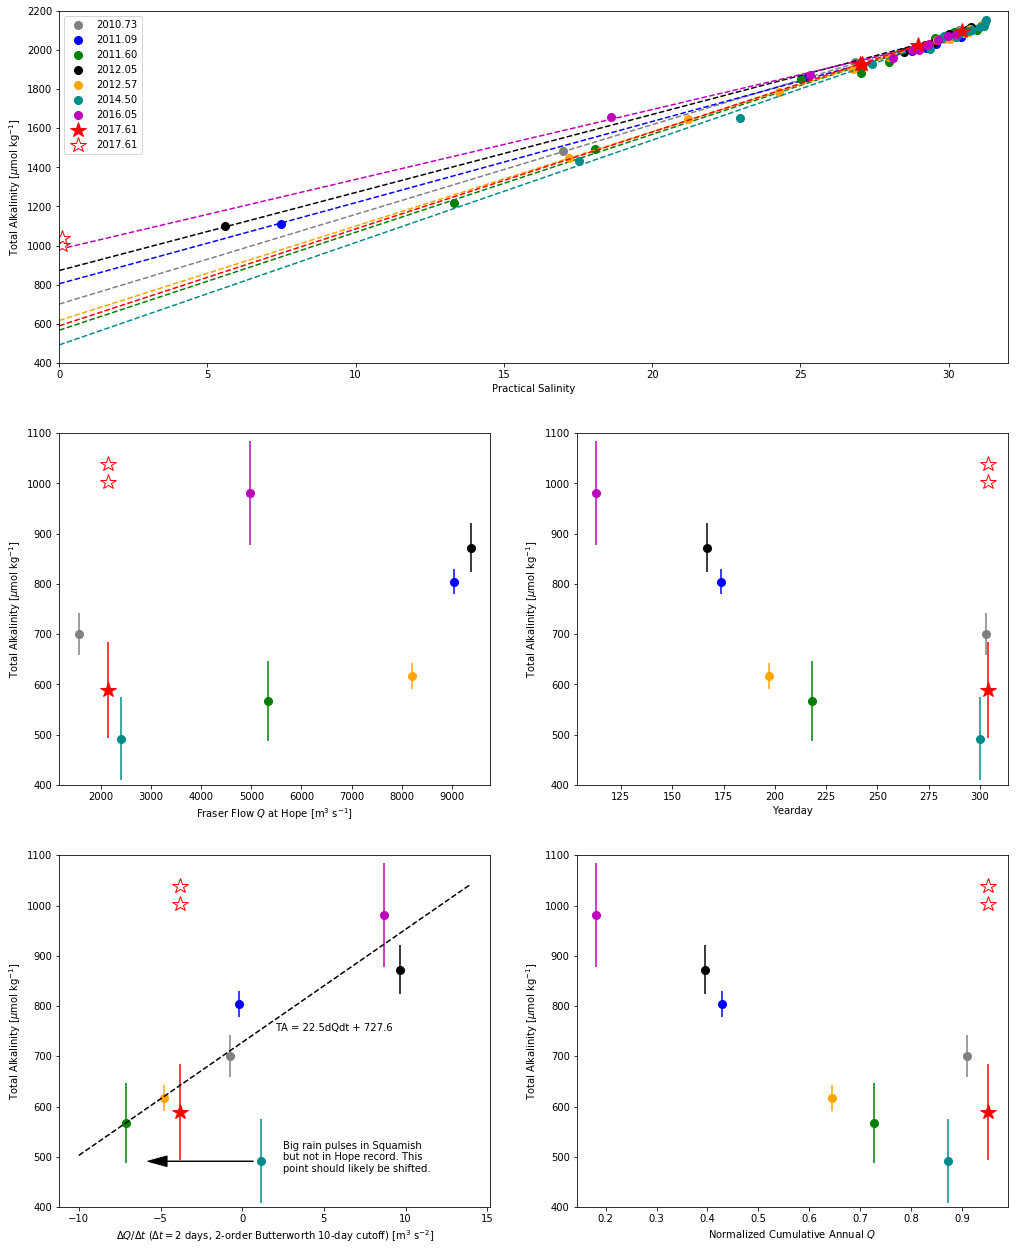

In [11]:
# Cruises to plot
cruises = [2010.73, 2011.09, 2011.60, 2012.05, 2012.57, 2014.50, 2016.05, 2017.61, 2017.61]
stations = [39.5, 42., 39.5, 42., 39.5, 42., 42., 1.5, 0.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'm', 'r', 'r']

# Make figure
fig = plt.figure(figsize=(17, 22))
gs = gridspec.GridSpec(3, 2)
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(2)])
axs.extend([fig.add_subplot(gs[2, col]) for col in range(2)])
axs[0].set_xlim([0, 32])
axs[0].set_ylim([400, 2200])
axs[0].set_xlabel('Practical Salinity')
axs[0].set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')
labels = [
    'Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]',
    'Yearday',
    '$\Delta Q/\Delta t$ ($\Delta t = 2$ days, 2-order Butterworth 10-day cutoff) [m$^{3}$ s$^{-2}$]',
    'Normalized Cumulative Annual $Q$',
]
for ax, label in zip(axs[1:], labels):
    ax.set_ylim([400, 1100])
    ax.set_xlabel(label)
    ax.set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')

x_reg, y_reg = [], []    

# ------------- Loop through cruises ------------------------
for cruise, station, color in zip(cruises, stations, colors):
    
    # Symbols
    if color is 'r':
        marker = '*'
        size = 16
    else:
        marker = 'o'
        size = 8
    
    # Index
    index = (
        (SOG_TA['crid'] == cruise) &
        (SOG_TA['stn'] == station) &
        ((SOG_TA['alk_qf'] == 2) | (SOG_TA['alk_qf'] == 6))
    )
    
    # Regressions
    if station == 0.5:
        facecolor = 'w'
    else:
        facecolor = color
        S_fit = sm.OLS(SOG_TA['alk'][index], sm.add_constant(SOG_TA['S'][index])).fit()
    
    # Flow metrics
    month, day = int(SOG_TA['mnth'][index][0]), int(SOG_TA['day'][index][0])
    flowindex = [
        abs(np.array(Fraser['date']) - datetime(int(cruise), *yearday)).argmin()
        for yearday in [[month, day], [1, 1], [12, 31]]
    ]
    intQ = Fraser['flow'][flowindex[1]: flowindex[0]].sum()/Fraser['flow'][flowindex[1]: flowindex[2]].sum()
    
    # Salinity Regression Plot
    axs[0].plot(
        SOG_TA['S'][index], SOG_TA['alk'][index],
        marker=marker, color=color,
        markersize=size, markerfacecolor=facecolor,
        linestyle='', label=f'{cruise:.2f}',
    )
    if station != 0.5:
        axs[0].plot(np.arange(30), S_fit.params[1] * np.arange(30) + S_fit.params[0], linestyle='--', color=color)
    
    # Endmember Plots
    metrics = [
        Fraser['flow'][flowindex[0]],
        (Fraser['date'][flowindex[0]] - Fraser['date'][flowindex[1]]).days,
        Fraser['dQdt'][flowindex[0]], intQ,
    ]
    for i, ax, x in zip(range(4), axs[1:], metrics):
        if station == 0.5:
            ax.plot(
                x*np.ones(sum(index)), SOG_TA['alk'][index],
                marker=marker, color=color,
                markerfacecolor=facecolor, markersize=size, linestyle='',
            )
        else:
            ax.plot(x, S_fit.params[0], marker=marker, color=color, markerfacecolor=facecolor, markersize=size)
            ax.errorbar(x, S_fit.params[0], S_fit.conf_int()[0][1] - S_fit.params[0], color=color)
            if i == 2 and cruise != 2014.50:
                x_reg.append(x)
                y_reg.append(S_fit.params[0])
                
dQdt_fit = sm.OLS(np.array(y_reg), sm.add_constant(np.array(x_reg))).fit()
axs[3].plot(np.arange(-10, 15), dQdt_fit.params[1] * np.arange(-10, 15) + dQdt_fit.params[0], 'k--')
axs[3].text(0.5, 0.5, f'TA = {dQdt_fit.params[1]:.1f}dQdt + {dQdt_fit.params[0]:.1f}', transform=axs[3].transAxes)
axs[3].text(0.52, 0.1, 'Big rain pulses in Squamish\nbut not in Hope record. This\npoint should likely be shifted.', transform=axs[3].transAxes)
axs[3].arrow(0.45, 0.13, -0.2, 0, head_width=0.03, fc='k', transform=axs[3].transAxes)
axs[0].legend()
plt.show()

## Fraser River Buoy pH Data

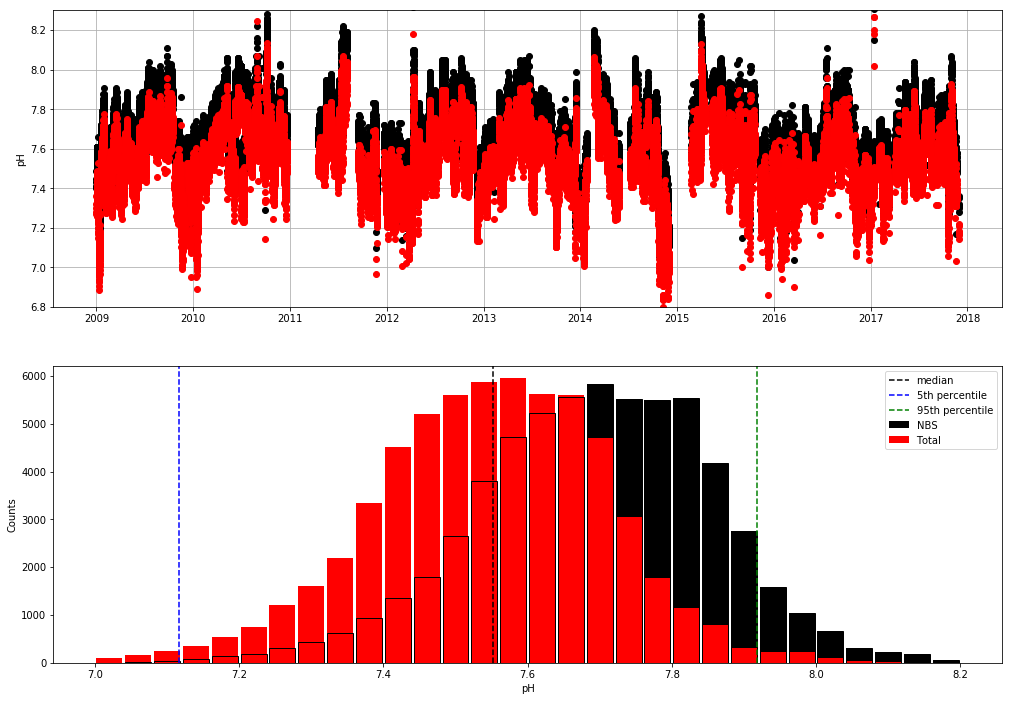

In [60]:
# pH Stats
median = np.nanmedian(buoy['pH']['total'])
percentile_5 = np.nanpercentile(buoy['pH']['total'], 1)
percentile_95 = np.nanpercentile(buoy['pH']['total'], 99)

# Make Figure
fig, ax = plt.subplots(2, 1, figsize=(17, 12))
ax[0].plot(buoy['date'], buoy['pH']['NBS'], 'ko')
ax[0].plot(buoy['date'], buoy['pH']['total'], 'ro')
ax[0].set_ylim([6.8, 8.3])
ax[0].set_ylabel('pH')
ax[0].grid()

ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', label='NBS')
ax[1].hist(buoy['pH']['total'][~np.isnan(buoy['pH']['total'])], bins=30, range=[7, 8.2], rwidth=0.9, color='r', label='Total')
ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', fill=False)
ax[1].plot([median, median], [0, 6200], 'k--', label='median')
ax[1].plot([percentile_5, percentile_5], [0, 6200], 'b--', label='5th percentile')
ax[1].plot([percentile_95, percentile_95], [0, 6200], 'g--', label='95th percentile')
ax[1].set_ylim([0, 6200])
ax[1].set_xlabel('pH')
ax[1].set_ylabel('Counts')
ax[1].legend()
plt.show()

## Freshwater DIC scenarios
Plot model freshwater DIC:TA as determined by TA and pH

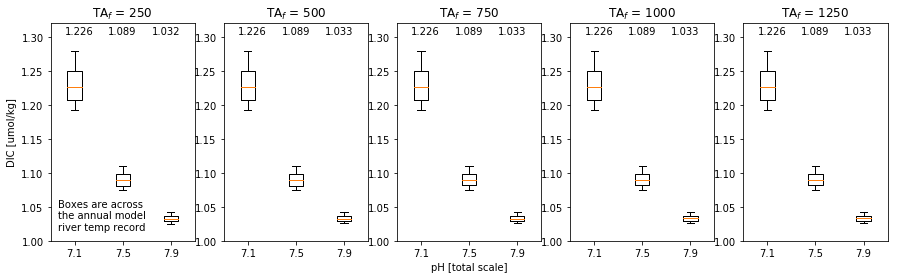

In [168]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
axs[0].set_ylabel('DIC [umol/kg]')
axs[2].set_xlabel('pH [total scale]')
axs[0].text(0.05, 0.05, 'Boxes are across\nthe annual model\nriver temp record', transform=axs[0].transAxes)
pHs = [7.1, 7.5, 7.9]
TAs = [250, 500, 750, 1000, 1250]
lims = [
    [150, 405],
    [400, 755],
    [700, 1055],
    [975, 1330],
    [1275, 1630],
]
for ax, lim, TA in zip(axs, lims, TAs):
    CO2 = []
    for pH, pos in zip(pHs, [0.1, 0.4, 0.7]):
        data = carbonate.calc_carbonate([TA, pH], 0, 0, np.arange(2.5, 19.4, 0.1), 0, 0, params=['TA', 'pH'])
        CO2.append(data['TC']/TA)
        ax.text(pos, 0.95, f'{np.nanmedian(data["TC"]/TA):.3f}', transform=ax.transAxes)
    ax.boxplot(CO2, labels=pHs)
    ax.set_ylim([1, 1.32])
    ax.set_title(f'TA$_f$ = {TA}')
plt.show()

## Flow Record

In [16]:
# Define color palette
colors = ['gray', 'b', 'g', 'lime', 'orange', 'darkcyan', 'm', 'r', 'lightsalmon', 'c', 'sienna', 'k']

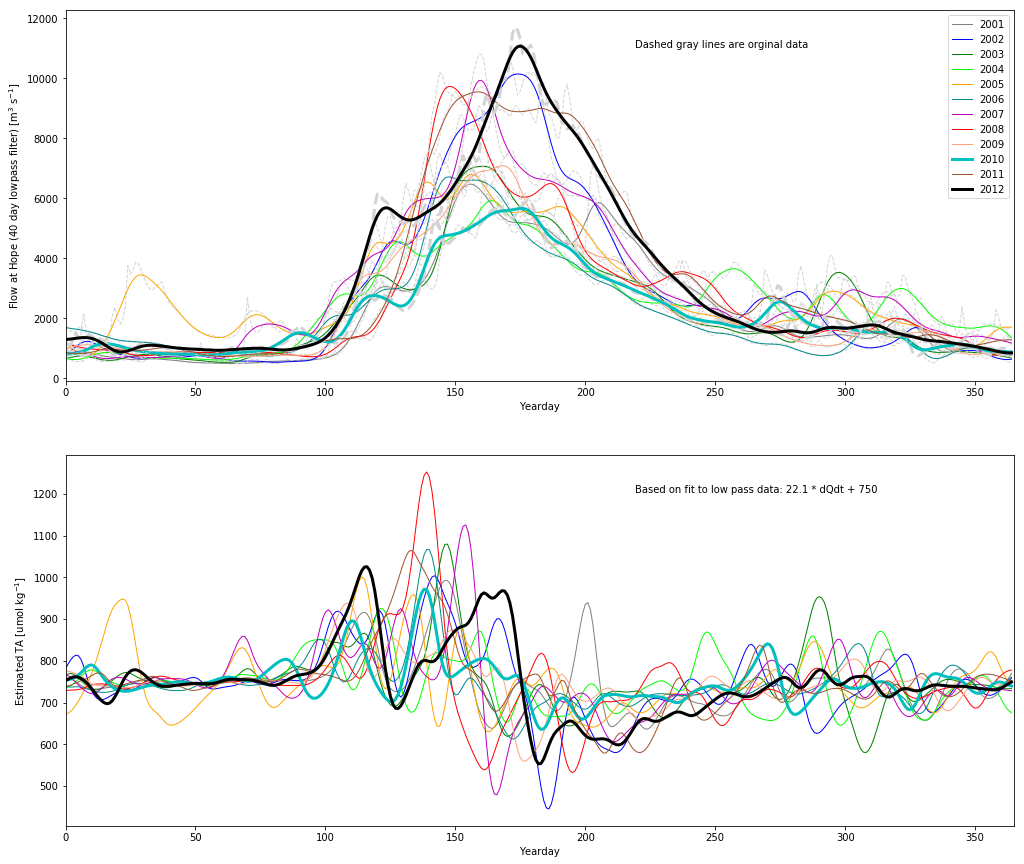

In [17]:
# Make figure
fig, ax = plt.subplots(2, 1, figsize=(17, 15))
ax[0].set_xlim([0, 365])
ax[0].set_xlabel('Yearday')
ax[0].set_ylabel('Flow at Hope (40 day lowpass filter) [m$^{3}$ s$^{-1}$]')
ax[1].set_xlim([0, 365])
ax[1].set_xlabel('Yearday')
ax[1].set_ylabel('Estimated TA [umol kg$^{-1}$]')
ax[0].text(0.6, 0.9, 'Dashed gray lines are orginal data', transform=ax[0].transAxes)
ax[1].text(0.6, 0.9, 'Based on fit to low pass data: 22.1 * dQdt + 750', transform=ax[1].transAxes)

# Loop through years
for year, color in zip(range(2001, 2013), colors):
    if year == 2010 or year == 2012:
        linewidth = 3
    else:
        linewidth = 1
    flowindex = [
        abs(np.array(Fraser['date']) - datetime(year, 1, 1) - timedelta(days=yearday)).argmin()
        for yearday in [0, 365]
    ]
    ax[0].plot(Fraser['flow'][flowindex[0]: flowindex[1]], '--', color='lightgrey', linewidth=linewidth)
    ax[0].plot(Fraser['flow_filter'][flowindex[0]: flowindex[1]], '-', color=color, label=str(year), linewidth=linewidth)
    ax[1].plot(22.1*Fraser['dQdt'][flowindex[0]: flowindex[1]] + 750, '-', color=color, linewidth=linewidth)
ax[0].legend()
plt.show()

## SOG Results

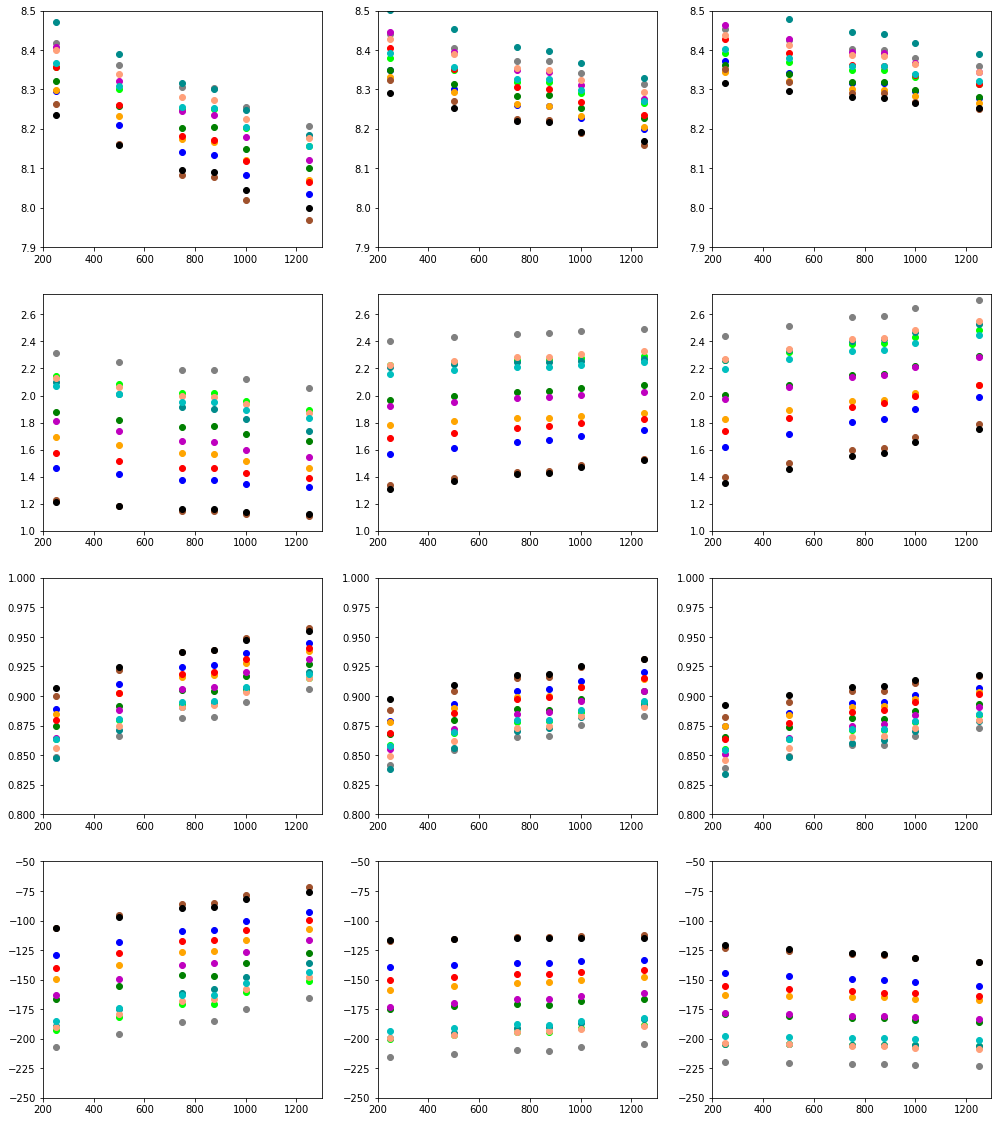

In [18]:
# Extract keys
years = list(SOG_results['72']['var'].keys())
TAs = list(SOG_results['72'].keys())
pHs = list(SOG_results.keys())

# Make Figure
fig, axs = plt.subplots(4, 3, figsize=(17, 20))
lims = [[7.9, 8.5], [1, 2.75], [0.8, 1], [-250, -50]]
params = ['pH', 'OmegaA', 'DICTA', 'DICminusTA']

# Loop through plots
for row, param, lim in zip(axs, params, lims):
    for ax, pH in zip(row, pHs):
        ax.set_ylim(lim)
        for TA in TAs:
            if TA is 'var':
                x = 875
            else:
                x = int(TA)
            for year, color in zip(years, colors):
                index = SOG_results[pH][TA][year]['SP'] < 20
                if param is 'pH':
                    y = SOG_results[pH][TA][year]['pH'][index]
                elif param is 'OmegaA':
                    y = SOG_results[pH][TA][year]['OmegaA'][index]
                elif param is 'DICTA':
                    y = SOG_results[pH][TA][year]['DIC'][index]/SOG_results[pH][TA][year]['TA'][index]
                elif param is 'DICminusTA':
                    y = SOG_results[pH][TA][year]['DIC'][index]-SOG_results[pH][TA][year]['TA'][index]
                ax.plot(x, y.mean(), 'o', color=color)